# Test ray tracing

Goal of this notebook is to use Cosmogrid simulations to test the raytracing pipeline, comparing it with theory

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import CMB_lensing_SBI
from CMB_lensing_SBI.healpy_utils import *
from CMB_lensing_SBI.PKDGRAV_utilities_scripts import *
from CMB_lensing_SBI.Raytracing import *
import CMB_lensing_SBI.Bornraytrace as Bornraytrace
import os
import healpy as hp
import astropy
import astropy.io.fits as fits
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM,wCDM
from astropy.cosmology import z_at_value
import frogress
import copy
import camb
from camb import model, initialpower
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import unyt
import yaml
from ekit import paths as path_tools
unyt.c.convert_to_units(unyt.km / unyt.s)

# short WL pipeline

In [10]:
# setup cosmology ********************
config = dict()
config['H0'] =  67.36
config['Om'] = 0.26
config['Ob'] = 0.0493
config['ns'] = 0.9649
config['s8'] = 0.84
config['nside'] = 128
cosmology = FlatLambdaCDM(H0= config['H0'] * u.km / u.s / u.Mpc, Om0=config['Om'])


k_tomo = dict()
cl_ = dict()
cl_ray = dict()
    
dictionary = np.load('../data/particles_{0}_nside_{1}.npy'.format(0,config['nside']),allow_pickle=True).item()
n_particles = dictionary['particles']
z_bin_edges = dictionary['z_edges'] 
comoving_edges = [cosmology.comoving_distance(x_) for x_ in np.array((z_bin_edges))]
un_ = comoving_edges[0].unit
comoving_edges = np.array([c.value for c in comoving_edges])
comoving_edges = comoving_edges*un_
    
# overdensity array
overdensity_array = []
for i in range(len(z_bin_edges)-1):
    overdensity_array.append(np.array(n_particles[i]/np.mean(n_particles[i])-1))
overdensity_array = np.array(overdensity_array)
    
# Initialise a raytrace object -----------------
raytrace_object = Raytracing(overdensity_array[:], cosmology, comoving_edges[:], config['nside'], NGP = False, volume_weighted = False)

#Full ray tracing
raytrace_object.raytrace_it()  
  
# Born Ray trace --------------
# new approach
kappa_lensing = np.copy(overdensity_array)*0.
for i in frogress.bar(np.arange(2,kappa_lensing.shape[0])):
    kappa_lensing[i-2] = Bornraytrace.raytrace(cosmology.H0, cosmology.Om0,
                         overdensity_array=overdensity_array[:(i),:].T,
                         a_centre=1./(1.+raytrace_object.redshifts[:i]), 
                         comoving_edges=comoving_edges[:(i+1)])
    

# old approach
kappa_lensing_old = np.copy(overdensity_array)*0.
for i in frogress.bar(np.arange(1,kappa_lensing.shape[0])):
    kappa_lensing_old[i-1] = Bornraytrace.raytrace(cosmology.H0, cosmology.Om0,
                         overdensity_array=overdensity_array[:(i),:].T,
                         a_centre=1./(1.+raytrace_object.redshifts[:i]), 
                         comoving_edges=comoving_edges[:(i+1)],old_approach=True)


100.0% | [##########] | Progress: 68 / 68 | Time: 0.6s | ETA: --0sss

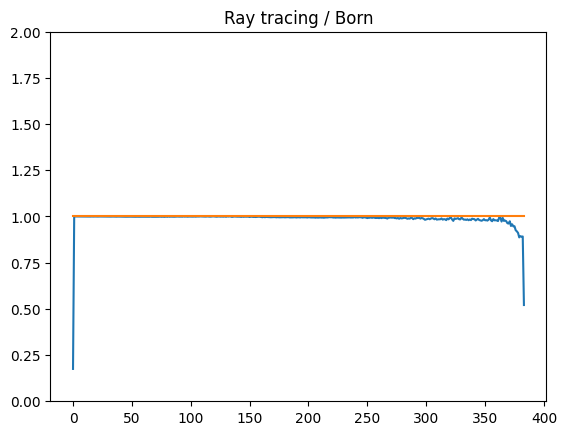

In [11]:
%matplotlib inline
i = 5

y = hp.anafast(raytrace_object.convergence_raytrace[i])/hp.anafast(kappa_lensing[i])
#y1 = hp.anafast(raytrace_object.convergence_raytrace[i])/hp.anafast(kappa_lensing_old[i])
plt.plot(y)
plt.plot(np.ones(len(y)))
#plt.plot(y1)
plt.ylim([0,2])
plt.title('Ray tracing / Born')
plt.show()